# ARIMA Modeling

In this section we're going to begin fitting our data to ARIMA models and make predictions about the increase of COVID-19 cases in America.  

Due to time constraints, we will only be modeling the states with the top 5 highest number of cases.  If you remember from notebook 2, those states are California, Florida, Georgia, New York, and Texas.

Time to get started!

# Importing Data

In [19]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')

from helper_functions import acf_pacf
from helper_functions import decompose_time_series
from helper_functions import train_test
from helper_functions import preprocess_data
from helper_functions import create_dataset
from helper_functions import fit_model

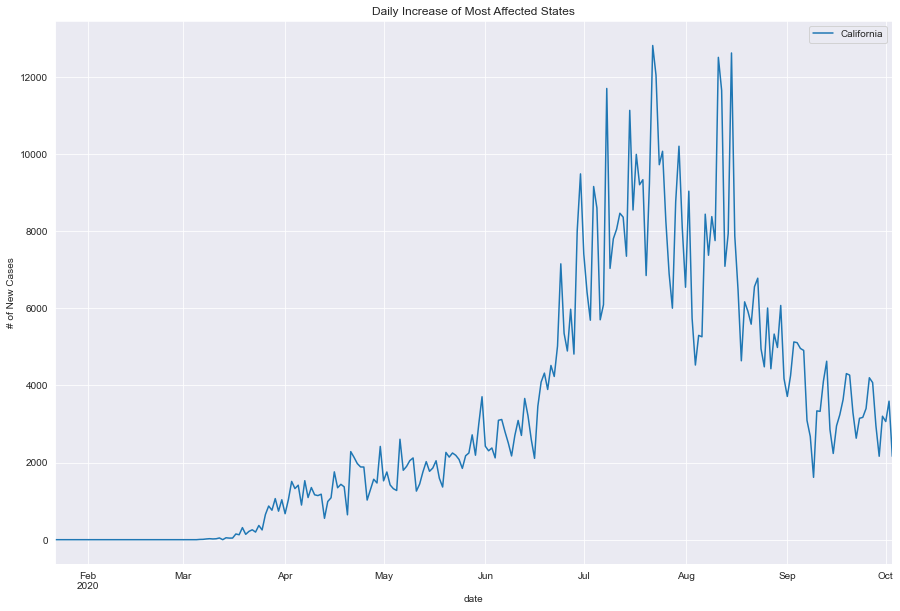

In [2]:
df = pd.read_csv('national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# California
ca = df['CA_positiveIncrease']
ca.plot(figsize=(15, 10), label='California')

plt.ylabel('# of New Cases')
plt.title('Daily Increase of Most Affected States')
plt.legend()
plt.show();

Awesome! We remember this messy plot from notebook 2!  Now, since we only have data between the end of January and the beginning of October, we shouldn't need to resample.  256 values per state is low enough, all things considered. If we resampled by the week, that would leave us with ~ 36 weeks, which might not be a enough data to get accurate data.

As you can see, none of these plots are stationary. Luckily, SARIMA allows us to integrate differencing by providing the arguments `d` and `D` in the order and seasonal order during   

Now that we've loaded the dataframe and subset our data, let's go ahead and get started.

# California

## Auto-Correlation and Decomposition
Since (S)ARIMA models require that you calculate the values for AR(p), MA(q), differencing, and seasonality, we'll first start by checking how strong the correlation between different lags and then move on to creating ACF and PACF plots to calculate the potential range for `q` and `p` respectively.  Afterwards we'll use decomposition to calculate the seasonality. 

## Calculating Q

In [3]:
def lag(df, n):
    '''
    Input: Dataframe and 'n' number of periods(int)
    Output: Dataframe that contains concatenation of the lag shifted data and 
    original dataframe.
    '''
    # Shift data by 'n' number of periods
    shift = df.shift(periods=n)
    
    # Concat new data with original dataframe
    concat = pd.concat([shift, df], axis=1)
    
    return concat

In [4]:
# California Auto-Correlation
ca_lag_1 = lag(ca, 1)

# Check correlation after day lag
ca_lag_1.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.925779
CA_positiveIncrease,0.925779,1.000000


Ok, as to be expected, it's very correlated after a single lag (equal to 1 day). Let's take a look at correlation after 7-days. 

In [5]:
ca_lag_7 = lag(ca, 7)
ca_lag_7.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.878137
CA_positiveIncrease,0.878137,1.000000


That's actually a pretty strong correlation after a week.  Because COVID-19 has an incubation period of up to 14 days, let's try 14 next.

In [6]:
ca_lag_14 = lag(ca, 14)

ca_lag_14.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.816383
CA_positiveIncrease,0.816383,1.000000


This is very interesting. There is still very high correlation.  Let's see how long this goes on for.

<Figure size 1440x1008 with 0 Axes>

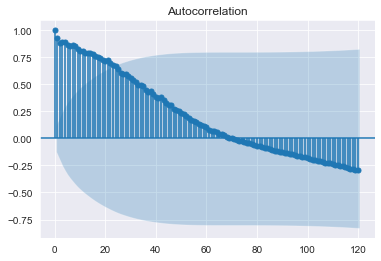

In [7]:
from statsmodels.graphics.tsaplots import plot_acf


plt.figure(figsize=(20,14))
plot_acf(ca, lags = 120);

According to the ACF plot, this correlation remains strong even when you count back 22 days!  This means that our q-value could potentially be up to 22, but let's check out the PACF plot and see which lags are significant. Also, notice how the ACF seems to tail off instead of cutting off. 

## Calculating P

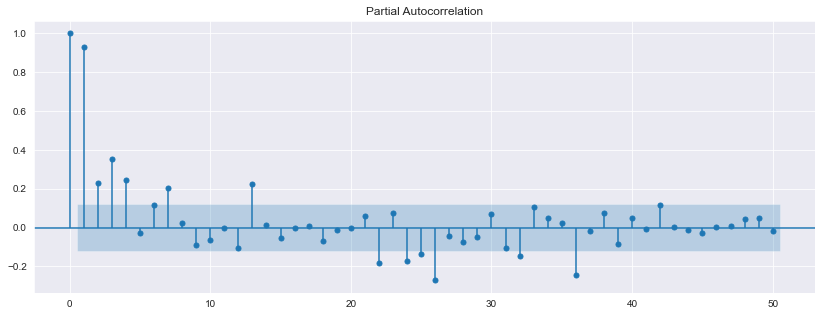

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5


plot_pacf(ca, lags=50);

The PACF plot tells us that the last 5 lags are the most significant. The plot also shows sharp drop in significance, so we're probably looking at an AR model.  So it would seem that our p-value is up to 5.  

Now let's find out the seasonality.

## Seasonality

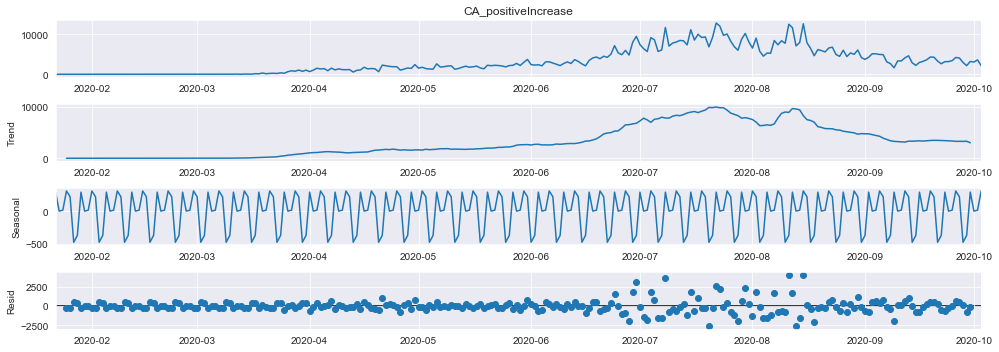

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_time_series(ca)

It appears that there are about 4 or 5 seasonal periods per month.  This seems to correspond to the number of weeks in a month.  So our s-value is 7 days.

## Bringing it all together

Now that we have our ranges for P, D, Q, and S, we can create a grid search to find the optimal parameters for our SARIMA model.

In [10]:
def pdq_parameters(timeseries, p_range = 2, d_range = 2, q_range = 2, s = 0):
    '''
    Input: Time Series Dataframe, range values for ARIMA(p, d, q), and an 
    optional value for seasonality (s).
    
    The function will generate values between within the given range (default 
    between 0 and 1) for p, d, and q, compile them into lists and run them 
    through a model fit to the given time series.
    
    It will return a list of the parameters and their associate AIC scores.  
    '''

    # Define the p, d and q parameters to take any value between 0 and 2
    p = range(p_range)
    d = range(d_range)
    q = range(q_range)

    # Generate all combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]

    # Finding optimal results
    results = []
    for combination in pdq:
        for combinations in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(timeseries,
                                                order=combination,
                                                seasonal_order=combinations,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False)

                output = mod.fit()
                results.append([combination, combinations, output.aic])
            
            except:
                continue
    return results

In [ ]:
ca_parameters = pdq_parameters(ca, p_range=6, d_range=2, q_range=6, s=7)

In [11]:
ca_parameters

NameError: name 'ca_parameters' is not defined

Now let's find out what the best parameters are.

In [12]:
def best_params(ts_param_list):
    '''
    Input: list of pdq parameters
    
    Function appends all AIC scores to a list, finds the minimum value, and 
    returns the corresponding parameters
    
    Output: Parameters for SARIMA Modeling
    '''

    # List for storing AIC values
    aic = []
    
    # Store AIC values
    for i in range(len(ts_param_list)):
        aic.append(ts_param_list[i][2])
    
    # List for storing best parameters. Using List in case there are multiple 
    # parameters that create the same AIC 
    best = []
    
    # Find parameters associated with lowest AIC
    for i in range(len(ts_param_list)):
        if ts_param_list[i][2] == min(aic):
            best.append(ts_param_list[i])

    return best

In [13]:
best_params(ca_parameters)

NameError: name 'ca_parameters' is not defined

So after 9 and a half hours we found our best parameters.  We'll have to do this four more times, meaning that we could potentially end up spending close to 48 hours just computing parameters.  Let's enlist the help of Auto ARIMA and compare AIC scores.  

The Auto-ARIMA function is a python derivative of a function used in the R programming language which finds the best seasonal and non-seasonal parameters and in a tiny fraction of the time.

In [14]:
import pmdarima as pm

ca_results = pm.auto_arima(ca,information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=6, max_q=22,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
ca_results

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4291.891, BIC=4313.139, Fit time=0.600 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4346.882, BIC=4353.964, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=4327.355, BIC=4341.520, Fit time=0.091 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4296.797, BIC=4310.962, Fit time=0.400 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4289.732, BIC=4307.438, Fit time=0.395 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4293.169, BIC=4307.334, Fit time=0.226 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 2, 7); AIC=4291.210, BIC=4312.458, Fit time=1.032 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=4293.375, BIC=4318.164, Fit time=0.638 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4285.260, BIC=4306.508, Fit time=0.171 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 1, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(1, 0, 1, 7), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

Ok, so the AIC is a little bit higher, but not by much, and we completed this in 15 seconds! For California, we'll use the parameters that we painstakingly waited for, but our other 4 states, we'll use Auto-ARIMA.  

Let's go ahead and split our data now.

In [15]:
df_train, df_test = train_test(df)

In [16]:
len(df_train.index)

205

Perfect! Dataframe is split now, so lets make training and test sets for California.

In [17]:
ca_train = df_train[['CA_positiveIncrease']]

ca_test = df_test[['CA_positiveIncrease']]

ca_train


,CA_positiveIncrease
date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-08-09,8373
2020-08-10,7751
2020-08-11,12500


## Fitting Model

In [20]:
def fit_model(series_train, series_test, pdq=(1,0,1),pdqs=(0,0,0,1)):
    model = sm.tsa.statespace.SARIMAX(series_train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return series_train, series_test, results

                                      SARIMAX Results                                      
Dep. Variable:                 CA_positiveIncrease   No. Observations:                  205
Model:             SARIMAX(3, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -1648.307
Date:                             Tue, 13 Oct 2020   AIC                           3306.614
Time:                                     13:13:07   BIC                           3323.030
Sample:                                 01-22-2020   HQIC                          3313.260
                                      - 08-13-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4290      0.047     -9.152      0.000      -0.521      -0.337
ar.L2         -0.4229      

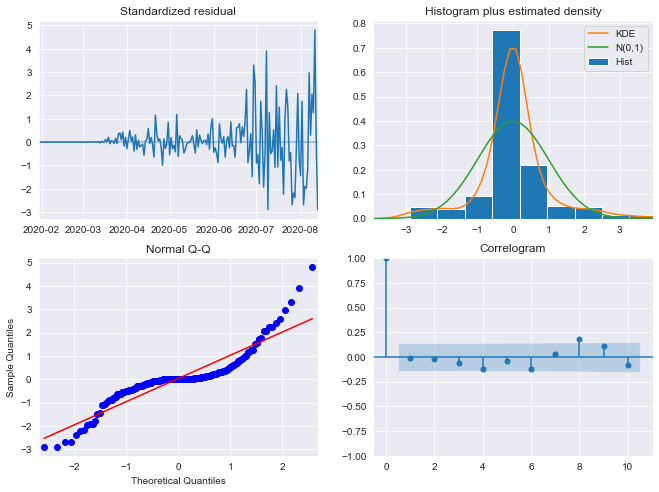

In [20]:
pdq = (3, 1, 0)
pdqs = (0, 1, 1, 7)
train, test, results = fit_model(ca_train, ca_test, pdq=pdq, pdqs=pdqs)

In [21]:
def test_RMSE(series_train, series_test, pdq, pdqs, display=True):
    X_train = series_train.values
    X_test = series_test.values
    train, test = X_train, X_test
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq,seasonal_order=pdqs)
        fit_model = model.fit(disp=0)
        output = fit_model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = np.sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-51:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()

def train_RMSE(train, results, display = True):
    train_pred = results.predict(-56)
    rmse = np.sqrt(MSE(train[-56:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()

SARIMA model RMSE on test data: 1204.54756


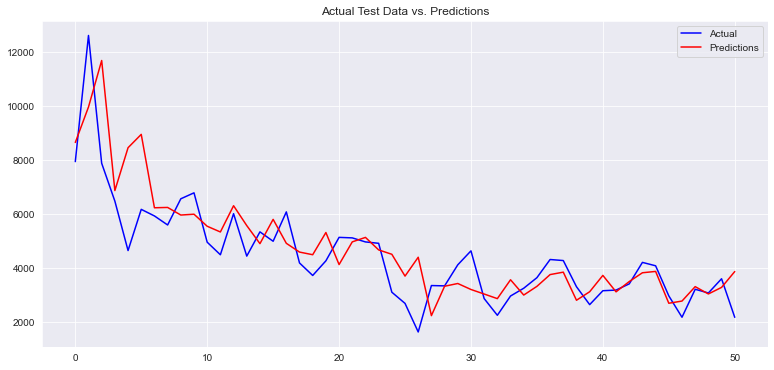

In [22]:
test_RMSE(ca_train, ca_test, pdq, pdqs)

SARIMA model RMSE on train data: 1838.36525


<Figure size 936x432 with 0 Axes>

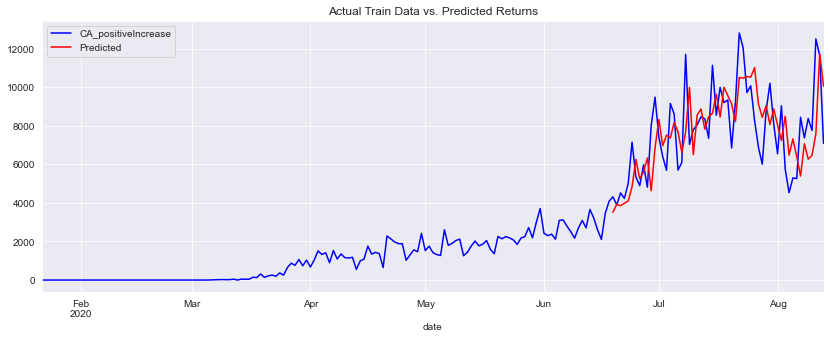

In [23]:
train_RMSE(ca_train, results)

In [24]:
pred1 = results.get_prediction(start=pd.to_datetime('2020-07-01'), dynamic=False)
pred_conf1 = pred1.conf_int()

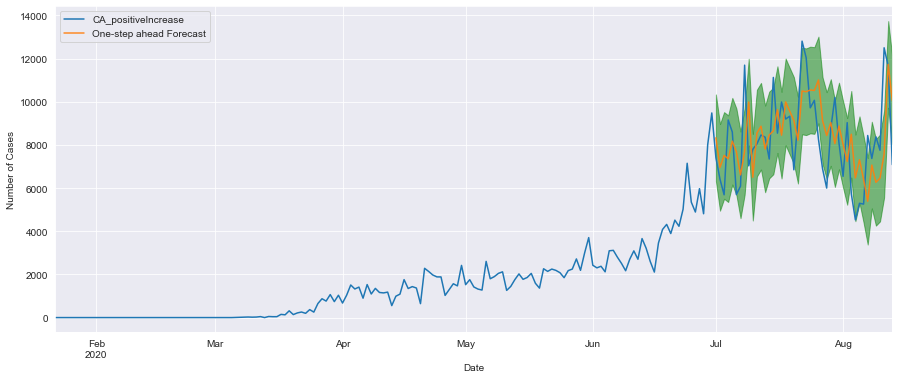

In [25]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = ca_train['2020-01-22':].plot(label='observed')

# Plot predicted values
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf1.index,
                pred_conf1.iloc[:, 0],
                pred_conf1.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cases')
plt.legend()

plt.show()

In [26]:
ca_model = sm.tsa.statespace.SARIMAX(ca_train, order=(1, 1, 1), 
                                  seasonal_order=(1, 1, 1, 12), 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

# Fit the model and print results
output = ca_model.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2188      0.090      2.445      0.015       0.043       0.394
ma.L1         -0.7627      0.060    -12.792      0.000      -0.880      -0.646
ar.S.L12      -0.1933      0.071     -2.704      0.007      -0.333      -0.053
ma.S.L12      -1.0187      0.325     -3.138      0.002      -1.655      -0.382
sigma2      1.148e+06   4.21e+05      2.725      0.006    3.22e+05    1.97e+06


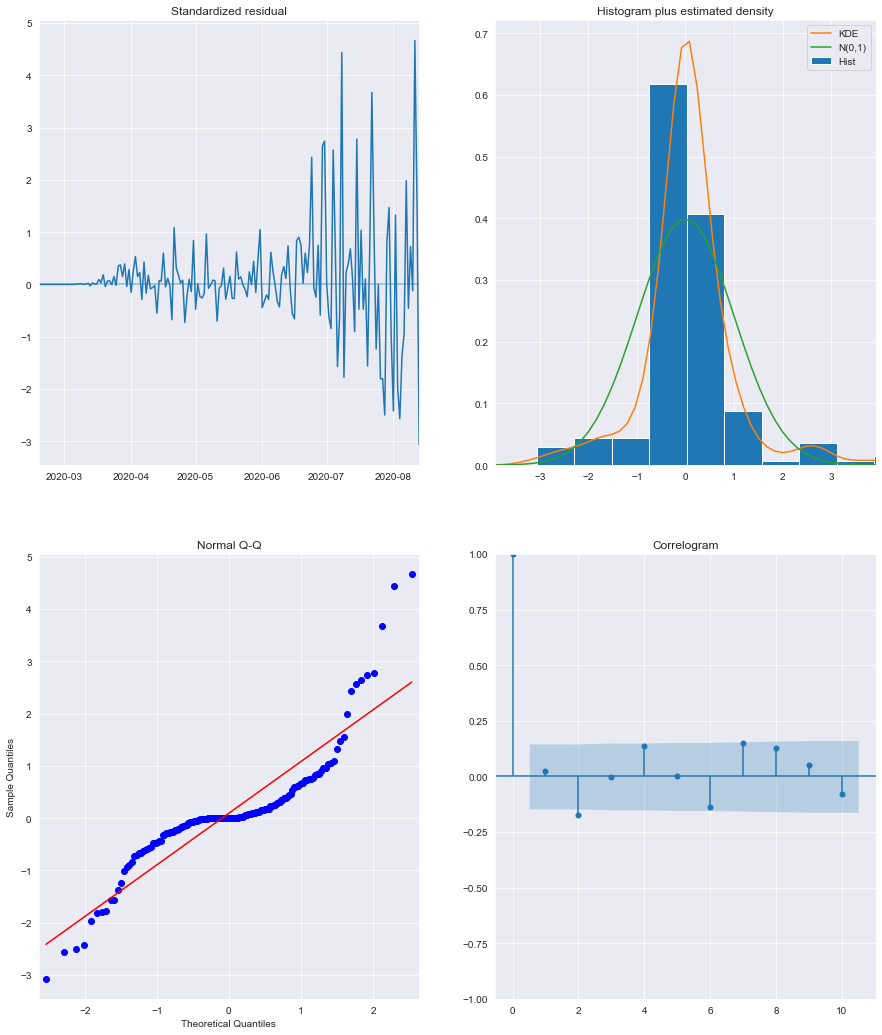

In [27]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [62]:
pred = output.get_prediction(start=pd.to_datetime('2020-07-01'), dynamic=False)
pred_conf = pred.conf_int()

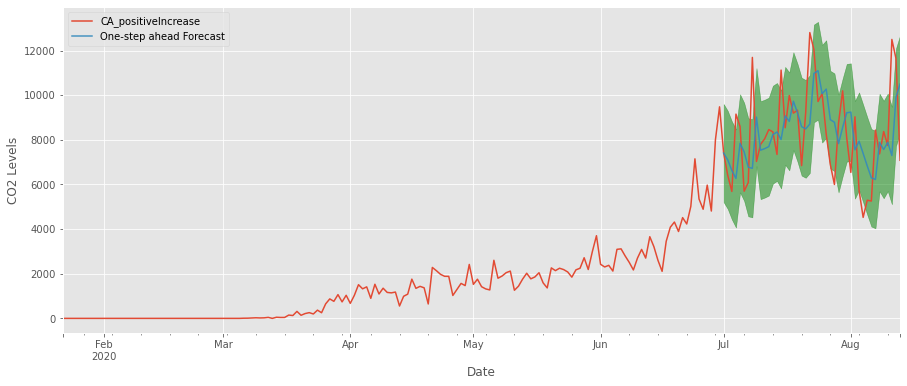

In [63]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = ca_train['2020-01-22':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

### Test Predictions

In [47]:
# Finding start date for Test df
ca_test.head()

,CA_positiveIncrease
date,
2020-08-14,7934
2020-08-15,12614
2020-08-16,7873
2020-08-17,6469
2020-08-18,4636


# Time Series Analysis with Long Short-Term Memory Neural Networks

In this notebook, we're going to utilize LSTM neural networks to help with time series forecasting.  While LSTMs were primarily used in Natural Language Processing and Speech Recognition, because they rely on past information to contextualize current information.  This is similar to how Time Series Analysis uses the values of the past to predict current and future values.  This similarity is the reason that LSTMs have become more popular in Time Series modeling and forecasting. 

We're going to measure how accurately our model can predict data that is a week out.

Before we get modeling, however, our data needs to be in a certain format before we feed it into our network.  Time for some more preprocessing!

## Converting from Time Series to Supervised Learning Problem
This might seem like a weird concept since Time Series Analysis IS a form of supervised learning, so let's clarify this.  In traditional ARMA and (S)ARIMA modeling, the data needs to be in a format of a series with the dates in the index (for easy manipulation) and the values in a column.  This means that your data is in a sequence.  For our LSTM to work, we need to change the data from a sequence to input (`X`) and output (`y`) pairs, where `X` is "today" (`t`) and `y` is equal to "tomorrow" (`t + 1`).  To do this, we'll need to scale our data and convert them from an array of values to a matrix.

### Scaling Data

A single LSTM layer will utilize a "forget gate", an "input gate", and an "output gate". Each of these gates use sigmoid function in one way or another.  Because of this, we're going to want to put our data on a scale of 0 to 1. We also want to normalize this data simply because the range of values is so large.  Each state has a minimum of 0 and will eventually have values in the thousands and ten thousands.  This scaling also helps to make our data more stationary, in a sense.

### Train, Validation, and Test Splits

Once we've scaled the data we'll split up the sets so that the validation has 14 days, and the test set has 7 days.  This should be a good split considering that the seasonality of the time series seems to be weekly across the board.

In [29]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test


In [30]:
ca_train, ca_val, ca_test = preprocess_data(ca, 'CA_positiveIncrease')

print(f"Train has {len(ca_train)} values")
print(f"Validation has {len(ca_val)} values")
print(f"Test has {len(ca_test)} values")

Train has 235 values
Validation has 7 values
Test has 14 values


In [30]:
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [31]:
look_back = 1

X_train, y_train = create_dataset(ca_train, look_back)
X_val, y_val = create_dataset(ca_val, look_back)
X_test, y_test = create_dataset(ca_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [32]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                    verbose=1, shuffle=False)

model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 2ms/step - loss: 0.1230 - val_loss: 0.0483
Epoch 2/500
233/233 [==============================] - 0s 77us/step - loss: 0.1145 - val_loss: 0.0417
Epoch 3/500
233/233 [==============================] - 0s 69us/step - loss: 0.1061 - val_loss: 0.0356
Epoch 4/500
233/233 [==============================] - 0s 77us/step - loss: 0.0980 - val_loss: 0.0300
Epoch 5/500
233/233 [==============================] - 0s 64us/step - loss: 0.0906 - val_loss: 0.0249
Epoch 6/500
233/233 [==============================] - 0s 82us/step - loss: 0.0832 - val_loss: 0.0204
Epoch 7/500
233/233 [==============================] - 0s 69us/step - loss: 0.0774 - val_loss: 0.0164
Epoch 8/500
233/233 [==============================] - 0s 77us/step - loss: 0.0718 - val_loss: 0.0130
Epoch 9/500
233/233 [==============================] - 0s 56us/step - loss: 0.0670 - val_loss: 0.0101
Epoch 10/500
233/233 [=================

In [33]:
from sklearn.metrics import mean_absolute_error as MAE

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train[0], train_predict[:,0]))

print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train[0], 
                                                   train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test[0], test_predict[:,0]))

print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test[0], 
                                                  test_predict[:,0])))

Train Mean Absolute Error: 2006.1271270620975
Train Root Mean Squared Error: 2391.5859602370315
Test Mean Absolute Error: 511.083455403646
Test Root Mean Squared Error: 643.4955524845961


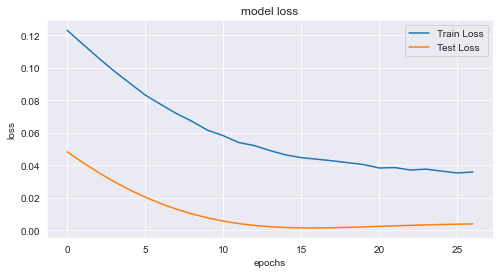

In [34]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

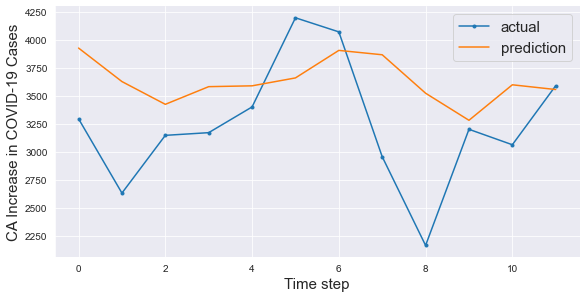

In [35]:
aa=[x for x in range(12)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:12], '-', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('CA Increase in COVID-19 Cases', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();